In [33]:
###--- libraries
import numpy as np
import pandas as pd
import scipy.sparse
import statistics
import csv
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

### Loading input dataset

In [34]:
df = pd.read_csv('../datasets/2014_AccidentSeverity.csv')
df.head(10)

,Tipo_accidente,Longitude,Diseño Via,Minute,Hour,Day_of_week,Day_of_year,Month,Latitude,Class
0,Otro,-75.559206,Tramo de via,15,5,2,1,1,6.266927,1
1,Atropello,-75.553463,Tramo de via,30,5,2,1,1,6.289380,1
2,Atropello,-75.607620,Tramo de via,37,5,2,1,1,6.234206,1
3,Atropello,-75.568271,Tramo de via,50,5,2,1,1,6.259997,1
4,Atropello,-75.550045,Tramo de via,0,6,2,1,1,6.264803,1
5,Choque,-75.592128,Tramo de via,20,6,2,1,1,6.281714,1
6,Choque,-75.595855,Tramo de via,30,6,2,1,1,6.257888,1
7,Caida Ocupante,-75.576754,Tramo de via,0,7,2,1,1,6.220039,1
8,Choque,-75.602693,Tramo de via,20,7,2,1,1,6.218910,1
9,Choque,-75.555587,Interseccion,0,9,2,1,1,6.284520,1


### Separating features (X) and classes (target variable, Y) in input dataset

In [35]:
x_cols = [c for c in df.columns if c != 'Class']
x = df[x_cols]
y = df['Class']

###--- Encoding categorical variables (Tipo_accidente, Diseñi via)
X = pd.get_dummies(x, prefix_sep='_', drop_first=True)

###--- Features (X)
X.head(10)

,Longitude,Minute,Hour,Day_of_week,Day_of_year,Month,Latitude,Tipo_accidente_Caida Ocupante,Tipo_accidente_Choque,Tipo_accidente_Incendio,...,Diseño Via_Interseccion,Diseño Via_Lote o Predio,Diseño Via_Paso Elevado,Diseño Via_Paso Inferior,Diseño Via_Paso a Nivel,Diseño Via_Pontón,Diseño Via_Puente,Diseño Via_Tramo de via,Diseño Via_Tunel,Diseño Via_Via peatonal
0,-75.559206,15,5,2,1,1,6.266927,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-75.553463,30,5,2,1,1,6.289380,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,-75.607620,37,5,2,1,1,6.234206,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-75.568271,50,5,2,1,1,6.259997,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-75.550045,0,6,2,1,1,6.264803,0,0,0,...,0,0,0,0,0,0,0,1,0,0
5,-75.592128,20,6,2,1,1,6.281714,0,1,0,...,0,0,0,0,0,0,0,1,0,0
6,-75.595855,30,6,2,1,1,6.257888,0,1,0,...,0,0,0,0,0,0,0,1,0,0
7,-75.576754,0,7,2,1,1,6.220039,1,0,0,...,0,0,0,0,0,0,0,1,0,0
8,-75.602693,20,7,2,1,1,6.218910,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9,-75.555587,0,9,2,1,1,6.284520,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [36]:
###--- Classes (Objective variable, Y)
y.head(10)

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
8    1
9    1
Name: Class, dtype: int64

count    41776.000000
mean         0.555295
std          0.496939
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: Class, dtype: float64


<Axes: >

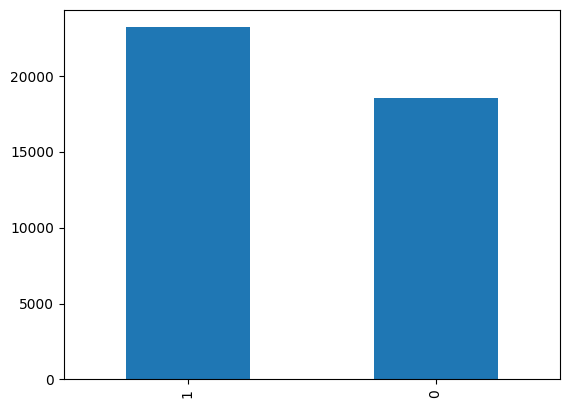

In [37]:
###--- Number of instances per class (0: Solo daños; 1: Con heridos)
print(df['Class'].describe())
df['Class'].value_counts().plot(kind = 'bar')

### Training and testing classifiers

In [38]:
def benchmark(clf,X,y):
    
    performance_sum = 0
    iterator = 0
    
    ###--- Stratified crosss validation using 5-folds
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    
    fold_counter = 0
    for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
        
        ###-- Splitting input data into training and test
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        fold_counter = fold_counter + 1
    
        ###--- Training a classifier in training data
        clf.fit(X_train, y_train)
        
        ###--- Testing a classifier in test data
        predictions_test = clf.predict_proba(X_test)
        
        ###--- Performance calculation (Y_predicted vs Y_test)
        result_test = roc_auc_score(y_test,predictions_test[:,1])
        
        performance_sum = performance_sum + result_test
        iterator = iterator + 1

        
    ###--- Averaged scored of classifier over the 5-folds
    final_score = performance_sum/iterator
    
    clf_descr = str(clf).split('(')[0]
        
    return final_score, clf_descr 

In [39]:
results_of_classifiers = []

###--- Calling function that trains and tests a classifier. One function call is done by each classifier

# KNeighborsClassifier
print('=' * 80)
print("KNeighborsClassifier")
results_of_classifiers.append(benchmark(KNeighborsClassifier(), X, y))

print('=' * 80)
print("RandomForestClassifier")
results_of_classifiers.append(benchmark(RandomForestClassifier(), X, y))

# SGD with Elastic Net penalty
print('=' * 80)
print("SGDClassifier")
results_of_classifiers.append(benchmark(SGDClassifier(loss = 'log_loss'), X, y))

#  MLPClassifier
print('=' * 80)
print("MLPClassifier")
results_of_classifiers.append(benchmark(MLPClassifier(), X, y))

# GaussianNB
print('=' * 80)
print("GradientBoostingClassifier")
results_of_classifiers.append(benchmark(GradientBoostingClassifier(), X, y))

KNeighborsClassifier
RandomForestClassifier
SGDClassifier
MLPClassifier
GradientBoostingClassifier


In [40]:
###---Performance in test of all trained classifiers
results_of_classifiers

[(0.6203275868751172, 'KNeighborsClassifier'),
 (0.8448363412687513, 'RandomForestClassifier'),
 (0.787437221305961, 'SGDClassifier'),
 (0.8339389321338322, 'MLPClassifier'),
 (0.8575791940565374, 'GradientBoostingClassifier')]

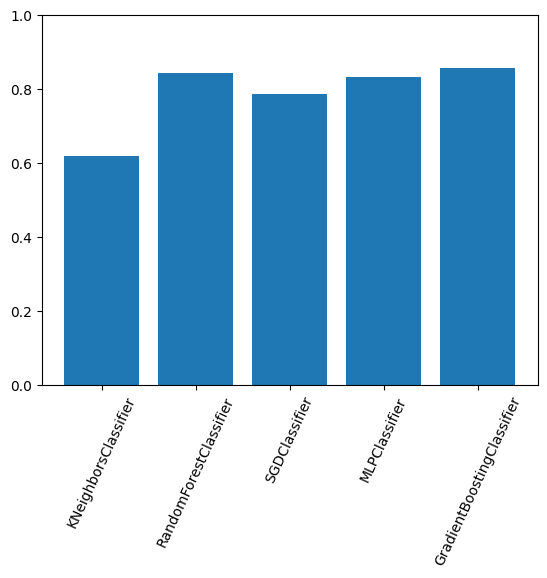

In [41]:
###---Plotting performance
plt.bar(range(len(results_of_classifiers)), [val[0] for val in results_of_classifiers], align='center')
plt.xticks(range(len(results_of_classifiers)), [val[1] for val in results_of_classifiers])
plt.xticks(rotation=65)
plt.ylim(0, 1.0)
plt.savefig('../results/plots/Classifiers_performance.png', bbox_inches='tight', dpi=600)